In [1]:
import torch
import torch_geometric
from torch_geometric.nn import radius_graph
from gns import data_loader
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

/home/yjc/Documents/gns-2/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check `train.py` Created with MPM Results

In [3]:
data_path = "../gns-data/datasets/sand-2d/train.npz"
npz_data = np.load(data_path, allow_pickle=True)
for id, trajectory in npz_data.items():
    print(f'MPM trajectory ID: {id}')
    print(f'Position data of trajectory: {trajectory[0].shape}')
    print(f'Material type:{trajectory[1].shape}')

MPM trajectory ID: simulation_trajectory_0
Position data of trajectory: (320, 6400, 2)
Material type:(6400,)
MPM trajectory ID: simulation_trajectory_1
Position data of trajectory: (320, 6400, 2)
Material type:(6400,)
MPM trajectory ID: simulation_trajectory_2
Position data of trajectory: (320, 6400, 2)
Material type:(6400,)
MPM trajectory ID: simulation_trajectory_3
Position data of trajectory: (320, 6400, 2)
Material type:(6400,)
MPM trajectory ID: simulation_trajectory_4
Position data of trajectory: (320, 6400, 2)
Material type:(6400,)
MPM trajectory ID: simulation_trajectory_5
Position data of trajectory: (320, 6400, 2)
Material type:(6400,)
MPM trajectory ID: simulation_trajectory_6
Position data of trajectory: (320, 6400, 2)
Material type:(6400,)
MPM trajectory ID: simulation_trajectory_7
Position data of trajectory: (320, 7200, 2)
Material type:(7200,)
MPM trajectory ID: simulation_trajectory_8
Position data of trajectory: (320, 4800, 2)
Material type:(4800,)


# See How torch `raius_graph` Works

All the nodes are conncected because all of the noede features are in each nodes connectivity radius.

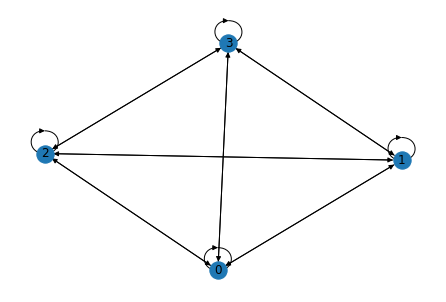

In [26]:
node_features = torch.tensor([[0, 0],
                              [1, 0],
                              [1, 1],
                              [0, 1]])

edge_index = radius_graph(
    node_features, r=2, batch=None, loop=True)

data = torch_geometric.data.Data(x=node_features, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=False, remove_self_loops=False)
# plt.figure()
nx.draw(g, with_labels=True)
plt.show()

See the shape of node features and edge features

In [9]:
data

Data(x=[4, 2], edge_index=[2, 16])

Beside these, you can look more into details about graph `data`.

In [14]:
print(data.keys)

['edge_index', 'x']


In [15]:
print(data['x'])

tensor([[0, 0],
        [1, 0],
        [1, 1],
        [0, 1]])


In [16]:
print(data['edge_index'])

tensor([[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
        [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]])


In [19]:
for key, item in data:
    print(f'{key} found in data')
    print(f'{item} found in data')

x found in data
tensor([[0, 0],
        [1, 0],
        [1, 1],
        [0, 1]]) found in data
edge_index found in data
tensor([[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
        [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]]) found in data


# Steps for Implementing Conservation of Mementum in GNS

## Shape of batch in GNS

Our `train.py` is a dictionary of "simulation_trajectories". Each has trajectory length of 320. The `data_loader_by_samples` samples a training examples ((positions, sequence of current 6 positions, dim), (next ground truth position)) for 2 batches

In [27]:
data_path = "../gns-data/datasets/sand-2d/"
ds = data_loader.get_data_loader_by_samples(path=f"{data_path}train.npz",
                                              input_length_sequence=6,
                                              batch_size=2,
                                              shuffle=False)

# length of ds is, (trajectory_length - 6)*(n_trajectory)/2
print(len(ds)) # 1413 =  (320-6)*9 / 2

# Look at the first 2 trajectory.
for i, ((position, particle_type, n_particles_per_example), labels) in enumerate(ds):
    if i == 1:
        break
    print(position.shape)  # torch.Size([12800, 6, 2])
    print(particle_type.shape)  # torch.Size([12800])
    print(n_particles_per_example.shape)  # torch.Size([2])
    print(n_particles_per_example)  # tensor([6400, 6400])
    print(labels.shape)  # torch.Size([12800, 2])
    print(i)

1413
torch.Size([12800, 6, 2])
torch.Size([12800])
torch.Size([2])
tensor([6400, 6400])
torch.Size([12800, 2])
0


## Play with similar artifitial batch

In [31]:
# As you can see, it is concatenated list of two batch
# Let's make try the similar array
node_features = [
    np.array([[x, y] for x in np.linspace(0, 1, 2) for y in np.linspace(0, 1, 2)]),
    np.array([[x, y] for x in np.linspace(1.5, 2.5, 2) for y in np.linspace(1.5, 2.5, 2)])
]
nparticles_per_example = [len(node_features[0]), len(node_features[1])]
node_features = np.concatenate(node_features)
radius = 1.5

# Batch_ids are the flattened ids (0 or 1) represents
# where the node features are come from which batch.
batch_ids = torch.cat(
    [torch.LongTensor([i for _ in range(n)]) for i, n in enumerate(nparticles_per_example)])

# radius_graph accepts r < radius not r <= radius
# A torch tensor list of source and target nodes with shape (2, nedges)
edge_index = radius_graph(
    torch.tensor(node_features), r=radius, batch=batch_ids, loop=False)
# edge_index = np.array(edge_index)

# sender and receiver
receiver = edge_index[0, :]
sender = edge_index[1, :]

/tmp/ipykernel_32199/929860915.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch_geometric.data.Data(x=torch.tensor(node_features), edge_index=torch.tensor(edge_index))


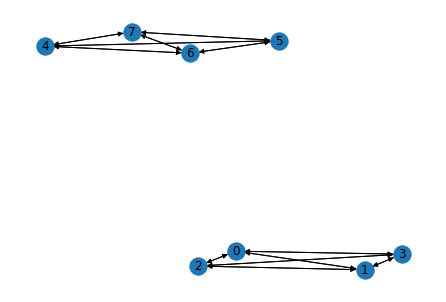

In [34]:
# Show graph connectivity plot
a = torch_geometric.data.Data(x=torch.tensor(node_features), edge_index=torch.tensor(edge_index))
g = torch_geometric.utils.to_networkx(a, to_undirected=False, remove_self_loops=False)
nx.draw(g, with_labels=True)
plt.show()

## Find edge index where sender==receiver

In [35]:
print(edge_index)
print(edge_index_inverted)

tensor([[1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2, 5, 6, 7, 4, 6, 7, 4, 5, 7, 4, 5, 6],
        [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7]])
tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7],
        [1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2, 5, 6, 7, 4, 6, 7, 4, 5, 7, 4, 5, 6]])


In [33]:
# Find edge index where sender==receiver
edge_index_inverted = torch.empty(edge_index.shape, dtype=torch.int64)
edge_index_inverted[[0, 1], :] = edge_index[[1, 0], :]

bidirectional_edge_index = torch.tensor(
    [[i, j+i] for i, sender2receiver in enumerate(edge_index.T)
            for j, receiver2sender in enumerate(edge_index_inverted.T[i:])
            if torch.equal(sender2receiver, receiver2sender)]
)
print(bidirectional_edge_index)

# for i, sender2receiver in enumerate(edge_index.T):
#     for j, receiver2sender in enumerate(edge_index_inverted.T[i:]):
#         if torch.equal(sender2receiver, receiver2sender):
#             print(i, j+i)

tensor([[ 0,  3],
        [ 1,  6],
        [ 2,  9],
        [ 4,  7],
        [ 5, 10],
        [ 8, 11],
        [12, 15],
        [13, 18],
        [14, 21],
        [16, 19],
        [17, 22],
        [20, 23]])
